# NLP for High Mortality Disease Detection
by Korey Bernhardt \
for DS785: Capstone \
12/11/2022


__General notes for running this notebook:__
* Several aspects use scispaCy, a python package for working with medical text. At the time this was written Python 3.6, 3.7, or 3.8 are needed to use this package as it doesn't work with Python 3.9.
* Installation of models used for scispaCy are included in the setup code, commented out.  This only needs to be run once.

## Setup
The following packages are used throughout the code.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import string
import csv
import time
from scipy.stats import randint

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import FitFailedWarning

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn import tree

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import spacy
import scispacy
from scispacy.linking import EntityLinker

import warnings
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

#turning off a few warnings that won't impact things at this point
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

#sometimes display gets confused about what it's refering to 
from IPython.display import display as display


In [2]:
# # The following is used with scispacy and only needs to be installed once ever.
# # en_core_sci_sm: A full spaCy pipeline for biomedical data.
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz

## Data Cleansing

### Read in data
Data is from Kaggle: https://www.kaggle.com/datasets/tboyle10/medicaltranscriptionshttps://www.kaggle.com/datasets/tboyle10/medicaltranscriptions\
\
Taken from: https://mtsamples.com/https://mtsamples.com/   \
\
Since the focus of this analysis is on transcriptions, rows without transcriptions are removed. \
Rows without keywords are also removed as they are used to generate labels for supervised learning models.

In [3]:
# Read in data
path = os.getcwd()
data = pd.read_csv(os.path.join('mtsamples.csv'), index_col=0) 

print('There are', len(data), 'rows.')
print(data['transcription'].isna().sum(), 'rows have no transcrptions.')
print(data['keywords'].isna().sum(), 'rows have no keywords.\n')

There are 4999 rows.
33 rows have no transcrptions.
1068 rows have no keywords.



In [4]:
# Starting distributions by medical specialty
count_df = pd.DataFrame(data['medical_specialty'].value_counts())
perct_df = pd.DataFrame(data['medical_specialty'].value_counts(normalize=True))
ms_df = pd.concat([count_df,perct_df], axis=1, keys=['counts', '%'])
display(ms_df)

,counts,%
,medical_specialty,medical_specialty
Surgery,1103,0.220644
Consult - History and Phy.,516,0.103221
Cardiovascular / Pulmonary,372,0.074415
Orthopedic,355,0.071014
Radiology,273,0.054611
General Medicine,259,0.051810
Gastroenterology,230,0.046009
Neurology,223,0.044609
SOAP / Chart / Progress Notes,166,0.033207


In [5]:
# Remove rows with no transcriptions or no keywords as these fields will be used in the modeling
data = data[data['transcription'].notna()]
data = data[data['keywords'].notna()]
data.reset_index(drop=True,inplace=True)
print(len(data), "rows have transcriptions and keywords.\n")

display(data.head())

3898 rows have transcriptions and keywords.



,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
# After removing empty transcriptions distributions by medical specialty
count_df = pd.DataFrame(data['medical_specialty'].value_counts())
perct_df = pd.DataFrame(data['medical_specialty'].value_counts(normalize=True))
ms_df = pd.concat([count_df,perct_df], axis=1, keys=['counts', '%'])
display(ms_df)


,counts,%
,medical_specialty,medical_specialty
Surgery,1021,0.261929
Orthopedic,303,0.077732
Cardiovascular / Pulmonary,280,0.071832
Radiology,251,0.064392
Consult - History and Phy.,234,0.060031
Gastroenterology,195,0.050026
Neurology,168,0.043099
General Medicine,146,0.037455
SOAP / Chart / Progress Notes,142,0.036429


Max keywords: 36
Median keywords: 13


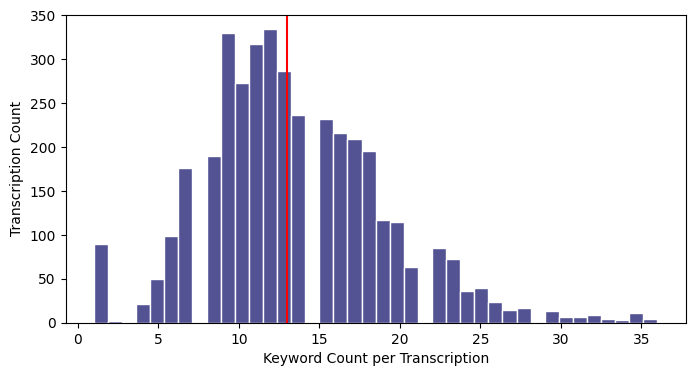

In [7]:
# Keyword visual
keywords_df = data.copy()
keywords_df['keywords']  = keywords_df['keywords'].str.rstrip(',')
keywords_df['keyword_count'] = (keywords_df['keywords'].str.count(','))+1
# keywords_df['keyword_count'] = keywords_df['keyword_count'].fillna(0)

kw_df = pd.DataFrame(keywords_df['keyword_count'].value_counts())
plt.figure(figsize=(8,4))
ax = sns.histplot(data=keywords_df, x="keyword_count",color='midnightblue',edgecolor="white")
# ax.set_xlim(1, 35)
plt.axvline(x=keywords_df['keyword_count'].median(),color='red')
ax.set_xlabel('Keyword Count per Transcription');ax.set_ylabel('Transcription Count'); 
# ax.set_title('Count of Keywords per Transcription'); 

print('Max keywords:', keywords_df['keyword_count'].max())
print('Median keywords:', int(keywords_df['keyword_count'].median()))

In [8]:
# unique keywords
allKeywords = ', '.join(data.apply(lambda x:pd.Series(data['keywords']),axis=1).stack().unique())
keyword_df = pd.DataFrame(data={"keyword": allKeywords.split(",")})
keyword_df['keyword'] = keyword_df['keyword'].str.strip()
keyword_df.drop_duplicates(inplace=True)
print("There are ", len(keyword_df), "unique keywords.\n")

There are  10327 unique keywords.



### Lemmatize Transcription and Keyword fields
This section will do the following:
* Remove header text from the transcription field so these aren't mistaken for medical terms. This will be stored in a transcription_clean field.
* Lemmatize the transcription_clean field and remove stop words, punctuation and numbers using a scispaCy model. This will be stored in a transcription_lemma field.
* Lemmatize the keyword field and remove stop words using a scispaCy model. This will be stored in a keyword_lemma field.

_This section can take several minutes to run_

In [9]:
# Funtions used for these sections
def get_headers(s):
    header_list = re.findall("[A-Z][A-Z][A-Z ]*:,|[A-Z][A-Z][A-Z ]*,",s)
    return(header_list)

def scispacy_lemmatizer(doc,rem_punct = True):
    # doc = nlp(text)
    lemma_text = []
    for token in doc:
        if rem_punct:
            if not token.is_stop and not token.is_digit and not token.is_punct:
                lemma_text.append(token.lemma_)
        else:
            if not token.is_stop:
                lemma_text.append(token.lemma_)
    lemma_string = ' '.join(map(str,lemma_text))
    return(lemma_string)

In [10]:
# Adjust header text so that it's consistent.
data['transcription_clean'] = data['transcription']
data['transcription_clean'] = data['transcription_clean'].str.replace(': ,',':,')
data['transcription_clean'] = data['transcription_clean'].str.replace(':  ,',':,')

nlp = spacy.load('en_core_sci_sm')
nlp.disable_pipe('parser')
nlp.add_pipe('sentencizer')

nlp2 = spacy.load('en_core_sci_sm') #keywords will be handled differently than transcriptions

In [11]:
#remove header text and lemmatize the transription and keyword fields
for i in range(len(data)):
    all_headers = []
    all_headers = list(get_headers(data.loc[i, 'transcription_clean']))
    for j in range(len(all_headers)):
            data.at[i,'transcription_clean'] = data.loc[i,'transcription_clean'].replace(all_headers[j],"")
    doc = nlp(data.loc[i, 'transcription_clean'])
    data.at[i,'transcription_lemma'] = scispacy_lemmatizer(doc)
    
    kywds = str(data.loc[i, 'keywords'])

    if kywds:
        doc2 = nlp2(kywds)
        data.at[i,'keywords_lemma'] = scispacy_lemmatizer(doc2,rem_punct=False)

display(data.head())

,description,medical_specialty,sample_name,transcription,keywords,transcription_clean,transcription_lemma,keywords_lemma
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",This 23-year-old white female presents with ...,23-year-old white female present complaint ...,"allergy / immunology , allergic rhinitis , all..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...","He has difficulty climbing stairs, difficulty...",difficulty climbing stair difficulty airline...,"bariatric , laparoscopic gastric bypass , weig..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",I have seen ABC today. He is a very pleasant...,see ABC today pleasant gentleman year old ...,"bariatric , laparoscopic gastric bypass , hear..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","2-D M- ,1. Left atrial enlargement with left ...",2-d m- left atrial enlargement leave atrial ...,"cardiovascular / pulmonary , 2-d m-mode , dopp..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",1. The left ventricular cavity size and wall ...,left ventricular cavity size wall thickness ...,"cardiovascular / pulmonary , 2-d , doppler , e..."


In [12]:
# View stopwords
stopwords = nlp.Defaults.stop_words

print("Count of stopwords:", len(stopwords))
print(stopwords)


Count of stopwords: 326
{'whither', 'becoming', 'five', 'hereafter', 'has', 'at', 'other', "n't", 'seemed', 'and', 'is', '‘ve', 'elsewhere', 'sixty', 'whereas', 'would', 'no', 'every', 'nowhere', 'until', 'us', 'whereby', 'afterwards', "'m", 'very', 'whereafter', 'by', 'anyone', 'whenever', 'from', 'much', 'everything', 'go', 'various', 'six', '‘s', 'bottom', 'everyone', 'in', 'ten', 'may', 'anywhere', 'can', 'some', 'except', 'amount', 'thus', 'keep', 'otherwise', 'most', 'hers', 'never', 'twenty', 'well', 'doing', 'give', 'mine', 'more', 'wherein', 'used', 'whom', 'ourselves', 'not', 'ca', '‘d', 'did', 'n’t', 'after', 'be', 'here', 'get', 'anyway', 'them', 'for', 'beforehand', 'unless', 'latter', 'cannot', "'ve", 'always', 'neither', 'both', 'several', 'make', 'above', 'meanwhile', "'s", 'ours', 'many', 'enough', 'when', 'due', 'fifty', 'twelve', 'alone', 'herein', 'via', 'nobody', '’ve', 'down', 'off', 'either', 'full', 'same', 'moreover', 'thereupon', 'why', 'she', 'onto', 'hereupo

### Create Disease Labels from Keywords
* This section uses scispaCy to link to the UMLS to get disease matches for keywords.
* There is a warning about unpickling an estimator from an older version of scikit learn. This is only being used to map the keywords to diseases and results appear as expected. It doesn't affect any other part of this process.

_Loading the linker can take a few minutes_

In [13]:
nlp3 = spacy.load('en_core_sci_sm')
nlp3.add_pipe("scispacy_linker", config={"linker_name": "umls", "threshold":0.8 })

C:\ProgramData\Anaconda3\envs\scispacy\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\ProgramData\Anaconda3\envs\scispacy\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
# Create disease labels field using en_core_sci_sm linked to the umls
data['disease_labels'] = None
data['disease_labels_count'] = 0

# Create df for analysis disease and score data being returned.
disease_df = pd.DataFrame(columns = ['transcript_index','concept_id', 'type', 'canonical_name','score'])

for i in range(len(data)):
    disease_list = []
    kywds = str(data.loc[i, 'keywords_lemma'])
    
    if kywds:
        doc = nlp3(kywds)
        
        for j in range(len(doc.ents)):
            entity = doc.ents[j]
            linker = nlp3.get_pipe("scispacy_linker")
        
            for umls_ent in entity._.kb_ents:
                umls_entity = linker.kb.cui_to_entity[umls_ent[0]]
                escore = umls_ent[1]

                for etype in umls_entity.types:
                    ename = umls_entity.canonical_name

                    if (etype == 'T047' or etype == 'T191') and ename not in disease_list: #T047: diseases, T191: cancers
                        disease_list.append(ename) 
                        disease_df.loc[len(disease_df.index)] = [i,umls_entity.concept_id, etype, umls_entity.canonical_name,escore] 
                       
        data.at[i,'disease_labels'] = disease_list
        data.at[i,'disease_labels_count'] = len(disease_list)

display(disease_df.head())
display(data.head())

,transcript_index,concept_id,type,canonical_name,score
0,0,C2607914,T047,Allergic rhinitis (disorder),1.000000
1,0,C0004096,T047,Asthma,1.000000
2,0,C0038218,T047,Status Asthmaticus,0.871917
3,0,C0035455,T047,Rhinitis,1.000000
4,0,C0009443,T047,Common Cold,0.801502


,description,medical_specialty,sample_name,transcription,keywords,transcription_clean,transcription_lemma,keywords_lemma,disease_labels,disease_labels_count
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",This 23-year-old white female presents with ...,23-year-old white female present complaint ...,"allergy / immunology , allergic rhinitis , all...","[Allergic rhinitis (disorder), Asthma, Status ...",6
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...","He has difficulty climbing stairs, difficulty...",difficulty climbing stair difficulty airline...,"bariatric , laparoscopic gastric bypass , weig...",[],0
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",I have seen ABC today. He is a very pleasant...,see ABC today pleasant gentleman year old ...,"bariatric , laparoscopic gastric bypass , hear...","[Myocardial Infarction, Old myocardial infarct...",6
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","2-D M- ,1. Left atrial enlargement with left ...",2-d m- left atrial enlargement leave atrial ...,"cardiovascular / pulmonary , 2-d m-mode , dopp...","[Neoplasm of cardiovascular system, Aortic val...",12
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",1. The left ventricular cavity size and wall ...,left ventricular cavity size wall thickness ...,"cardiovascular / pulmonary , 2-d , doppler , e...","[Neoplasm of cardiovascular system, Aortic val...",3


In [15]:
# Get counts of transcripts per disease for further analysis
def get_list_elem(series):
    elem = pd.Series([x for _list in series for x in _list])
    return (elem)

disease_counts = get_list_elem(data['disease_labels']).value_counts()
display(disease_counts.head())

# disease_counts.to_csv(os.path.join('disease_counts.csv')) 

Neoplasm of cardiovascular system    295
Neoplasms                            147
cervical cancer                      142
Adenohypophyseal Diseases            105
Urinary Bladder Diseases             101
dtype: int64

### Disease Aggregation


In [16]:
# Read in disease aggregation mapping file as a dicitonary. This was manually compiled using the disease_counts data generated above.
reader = csv.reader(open('disease_aggregation.csv', 'r'))
disease_mapping = {}
for row in reader:
    k, v = row
    disease_mapping[k] = v


In [17]:
# Map the data to the aggregated disease labels.
data['agg_labels'] = None

for i in range(len(data)):
    new_list = []
    d_labels = data.loc[i, 'disease_labels']
    
    if d_labels:
        for j in range(len(d_labels)):
            k = d_labels[j]

            if d_labels[j] in disease_mapping:
                v = disease_mapping[k]
            
                if disease_mapping[d_labels[j]] not in new_list:
                    new_list.append(v)
                
    data.at[i,'agg_labels'] = new_list
display(data.head())        

,description,medical_specialty,sample_name,transcription,keywords,transcription_clean,transcription_lemma,keywords_lemma,disease_labels,disease_labels_count,agg_labels
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",This 23-year-old white female presents with ...,23-year-old white female present complaint ...,"allergy / immunology , allergic rhinitis , all...","[Allergic rhinitis (disorder), Asthma, Status ...",6,[]
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...","He has difficulty climbing stairs, difficulty...",difficulty climbing stair difficulty airline...,"bariatric , laparoscopic gastric bypass , weig...",[],0,[]
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",I have seen ABC today. He is a very pleasant...,see ABC today pleasant gentleman year old ...,"bariatric , laparoscopic gastric bypass , hear...","[Myocardial Infarction, Old myocardial infarct...",6,[]
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","2-D M- ,1. Left atrial enlargement with left ...",2-d m- left atrial enlargement leave atrial ...,"cardiovascular / pulmonary , 2-d m-mode , dopp...","[Neoplasm of cardiovascular system, Aortic val...",12,[]
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",1. The left ventricular cavity size and wall ...,left ventricular cavity size wall thickness ...,"cardiovascular / pulmonary , 2-d , doppler , e...","[Neoplasm of cardiovascular system, Aortic val...",3,[]


In [18]:
# Create a new df with single aggregated labels, and only rows with an aggregated label.
# This will intentially duplicate rows that have multiple agg labels. 
data_labeled = pd.DataFrame()

for j in range(len(data)):
    d_labels = data.loc[j, 'agg_labels']
    
    for i in range(len(d_labels)):
        data_labeled = data_labeled.append(data.loc[j], ignore_index = True)
        dl_index = len(data_labeled)-1
        data_labeled.at[dl_index,'disease'] = d_labels[i]

print("There are", len(data_labeled), "transcription records with single disease labels.\n")
display(data_labeled.head())  


There are 1173 transcription records with single disease labels.



,description,medical_specialty,sample_name,transcription,keywords,transcription_clean,transcription_lemma,keywords_lemma,disease_labels,disease_labels_count,agg_labels,disease
0,Neck exploration; tracheostomy; urgent flexib...,Cardiovascular / Pulmonary,Tracheostomy,"PREOPERATIVE DIAGNOSES,Airway obstruction seco...","cardiovascular / pulmonary, airway, laryngolog...",Airway obstruction secondary to severe subglot...,airway obstruction secondary severe subglottic...,"cardiovascular / pulmonary , airway , laryngol...","[Neoplasm of cardiovascular system, Chondrogen...",10,[Cancers],Cancers
1,"The patient is a 17-year-old female, who pres...",General Medicine,Airway Compromise & Foreign Body - ER Visit,"HISTORY OF PRESENT ILLNESS:, The patient is a...","general medicine, diabetes, hypertension, asth...","The patient is a 17-year-old female, who pre...",patient 17-year-old female present emergenc...,"general medicine , diabete , hypertension , as...","[Diabetes Mellitus, Hypertensive disease, Dias...",7,[Diabetes],Diabetes
2,Whole body radionuclide bone scan due to pros...,Urology,Whole Body Radionuclide Bone Scan,"INDICATION:, Prostate Cancer.,TECHNIQUE:, 3....","urology, prostate cancer, technetium, whole bo...","Prostate Cancer., 3.5 hours following the i...",Prostate Cancer 3.5 hour follow intraveno...,"urology , prostate cancer , technetium , body ...","[Malignant neoplasm of prostate, Prostate carc...",3,[Cancers],Cancers
3,Transurethral resection of the bladder tumor ...,Urology,TURBT - 1,"PREOPERATIVE DIAGNOSIS: ,Bladder cancer.,POST...","urology, transurethral resection of the bladde...","Bladder cancer., Bladder cancer.,Transurethral...","Bladder cancer Bladder cancer.,transurethral r...","urology , transurethral resection bladder tumo...","[Malignant neoplasm of urinary bladder, Bladde...",11,"[Cancers, Kidney Diseases]",Cancers
4,Transurethral resection of the bladder tumor ...,Urology,TURBT - 1,"PREOPERATIVE DIAGNOSIS: ,Bladder cancer.,POST...","urology, transurethral resection of the bladde...","Bladder cancer., Bladder cancer.,Transurethral...","Bladder cancer Bladder cancer.,transurethral r...","urology , transurethral resection bladder tumo...","[Malignant neoplasm of urinary bladder, Bladde...",11,"[Cancers, Kidney Diseases]",Kidney Diseases


In [19]:
# final distributions by medical specialty
count_df = pd.DataFrame(data_labeled['medical_specialty'].value_counts())
perct_df = pd.DataFrame(data_labeled['medical_specialty'].value_counts(normalize=True))
ms_df = pd.concat([count_df,perct_df], axis=1, keys=['counts', '%'])

print('Final number of medical specialties in data for modeling:',len(ms_df))
display(ms_df)

Final number of medical specialties in data for modeling: 34


,counts,%
,medical_specialty,medical_specialty
Surgery,272,0.231884
Cardiovascular / Pulmonary,91,0.077579
Radiology,78,0.066496
Gastroenterology,74,0.063086
Consult - History and Phy.,67,0.057118
Nephrology,52,0.044331
General Medicine,51,0.043478
SOAP / Chart / Progress Notes,49,0.041773
Neurology,48,0.040921


#### Model Data Prep

In [20]:
model_data = data_labeled.copy()
model_data['content'] = model_data['transcription_lemma']
model_data['content'] = model_data['content'].fillna('')
model_data['label'] = model_data['disease']

model_data['cancer'] = 0
model_data.loc[(model_data['label'] == 'Cancers'), 'cancer'] = 1

model_data = model_data[['content','label','cancer']]
model_data

,content,label,cancer
0,airway obstruction secondary severe subglottic...,Cancers,1
1,patient 17-year-old female present emergenc...,Diabetes,0
2,Prostate Cancer 3.5 hour follow intraveno...,Cancers,1
3,"Bladder cancer Bladder cancer.,transurethral r...",Cancers,1
4,"Bladder cancer Bladder cancer.,transurethral r...",Kidney Diseases,0
...,...,...,...
1168,acute coronary syndrome procedure cardiac c...,Heart Diseases,0
1169,ch pain lack oxygen heart occur man age old ...,Heart Diseases,0
1170,short patient 55-year-old gentleman long-sta...,Heart Diseases,0
1171,medical condition drive surgery include hype...,Diabetes,0


##### TFIDF Vectorization

In [21]:
# Define a TF-IDF Vectorizer Object.
tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1,3),max_features = 1000)
tfidf_matrix = tfidf.fit_transform(model_data['content'])

# Output the shape of tfidf_matrix
print("Original TFIDF Matrix size:",tfidf_matrix.shape)

# Reduce the features
pca = PCA(n_components=0.95,whiten=True,svd_solver='full' )
tfIdfMat_reduced = pca.fit_transform(tfidf_matrix.toarray())
print("PCA Reduced TFIDF Matrix size:",tfIdfMat_reduced.shape)

Original TFIDF Matrix size: (1173, 1000)
PCA Reduced TFIDF Matrix size: (1173, 321)


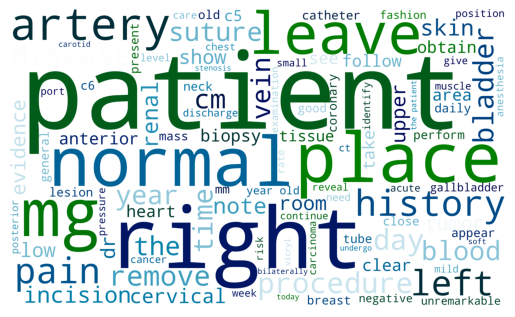

In [22]:
# Word cloud of top feature names
feature_names = tfidf.get_feature_names()
dense = tfidf_matrix.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
df.T.sum(axis=1)
cloud = WordCloud(width = 5000, height = 3000, random_state=1,background_color="white", max_words=100, colormap='ocean').generate_from_frequencies(df.T.sum(axis=1))
plt.figure()
plt.imshow(cloud)
plt.axis("off")
plt.show()

##### Train/Test Data

In [23]:
labels = model_data['label'].tolist()
category_list = model_data['label'].unique()

x_train, x_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels, random_state=1)   
print('Train data:',x_train.shape)
print('Test data:',x_test.shape)

# Some models will use scaled data. Scaling test and train inputs.
scaler = StandardScaler()  
scaler.fit(x_train)  
x_train_sc = scaler.transform(x_train)  
x_test_sc = scaler.transform(x_test) 

#for binary testing
labels_b = model_data['cancer'].tolist()
category_list_b = model_data['cancer'].unique()

x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(tfIdfMat_reduced, labels_b, stratify=labels_b, random_state=1)   
print('Train data:',x_train_b.shape)
print('Test data:',x_test_b.shape)

# Some models will use scaled data. Scaling test and train inputs.
scaler = StandardScaler()  
scaler.fit(x_train_b)  
x_train_b_sc = scaler.transform(x_train_b)  
x_test_b_sc = scaler.transform(x_test_b) 

Train data: (879, 321)
Test data: (294, 321)
Train data: (879, 321)
Test data: (294, 321)


## Basic Analysis
Visuals to help understand the data that will be modeled.

### Count of Transcripts

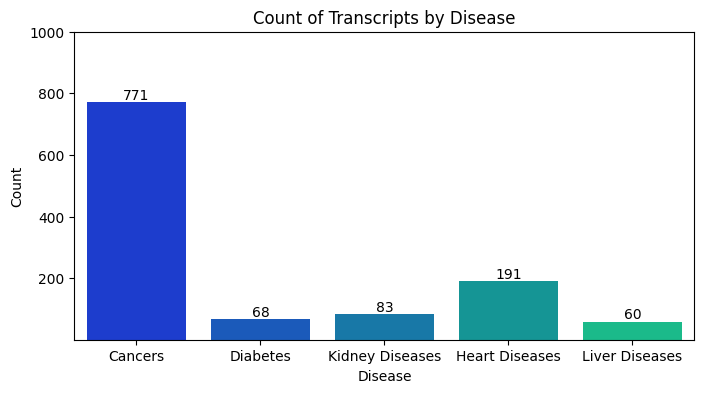

In [24]:
# count of transcripts by label
plt.figure(figsize=(8,4))
ax = sns.countplot(x='disease', data=data_labeled, palette="winter")
ax.set_xlabel('Disease');ax.set_ylabel('Count'); 
ax.set_title('Count of Transcripts by Disease'); 
ax.set_ylim(1, 1000)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

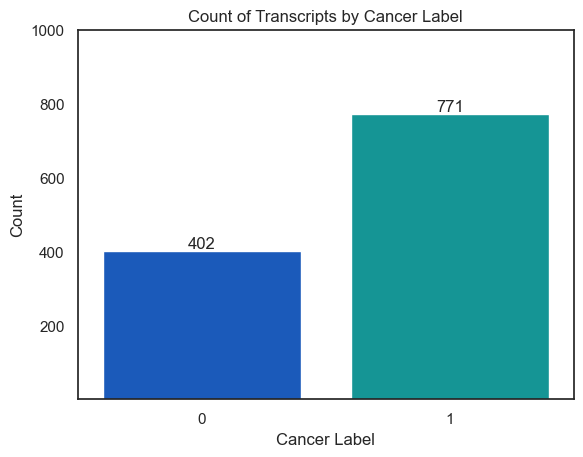

In [25]:
# plt.figure(figsize=(8,4))
sns.set_theme(style='white')
ax = sns.countplot(x='cancer', data=model_data, palette="winter")
ax.set_xlabel('Cancer Label');ax.set_ylabel('Count'); 
ax.set_title('Count of Transcripts by Cancer Label'); 
ax.set_ylim(1, 1000)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

### Word Counts

Median word count 383.0
Max word count 1814
Min word count 1


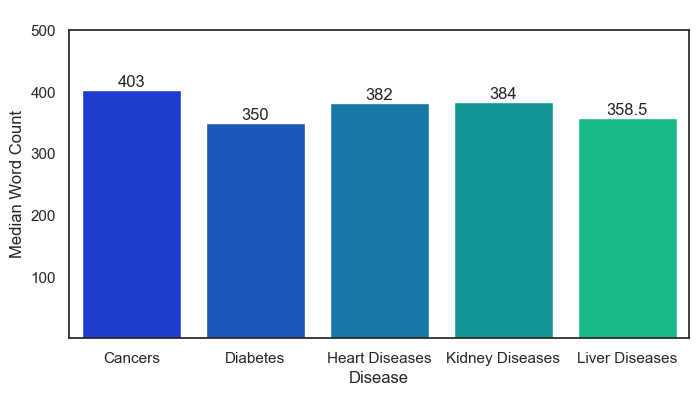

In [26]:
# word count distribution
data_labeled['word_count'] = data_labeled['transcription_clean'].apply(lambda x: len(str(x).split(' ')))
disease_median = pd.DataFrame(data_labeled.groupby('disease')['word_count'].median())
disease_median.reset_index(inplace=True)

print('Median word count',data_labeled['word_count'].median())
print('Max word count',data_labeled['word_count'].max())
print('Min word count',data_labeled['word_count'].min())

plt.figure(figsize=(8,4))
ax = sns.barplot(x='disease', y='word_count', data=disease_median,palette="winter")
ax.set_xlabel('Disease');ax.set_ylabel('Median Word Count'); 
ax.set_title(' '); 
ax.set_ylim(1, 500)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()
# Median Word Count in Transcripts by Disease

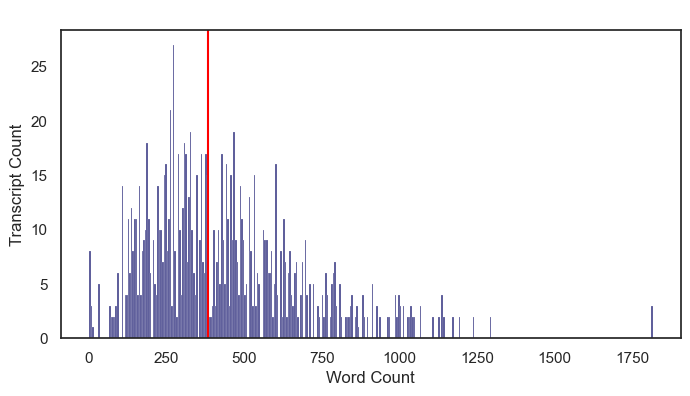

In [27]:
plt.figure(figsize=(8,4))
ax = sns.histplot(data=data_labeled, x="word_count",binwidth=5,color='midnightblue',edgecolor="white")
plt.axvline(x=data_labeled['word_count'].median(),color='red')
ax.set_xlabel('Word Count');ax.set_ylabel('Transcript Count'); 
ax.set_title(' '); 
# ax.set_ylim(1, 500)
plt.show()

# Word Count in Transcripts

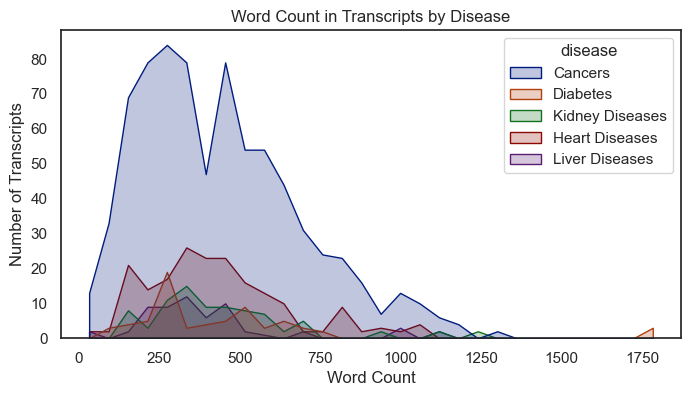

In [28]:
plt.figure(figsize=(8,4))
ax = sns.histplot(data=data_labeled, x="word_count",hue="disease",element="poly",palette='dark')
ax.set_xlabel('Word Count');ax.set_ylabel('Number of Transcripts'); 
ax.set_title('Word Count in Transcripts by Disease'); 
# ax.set_ylim(1, 500)
plt.show()

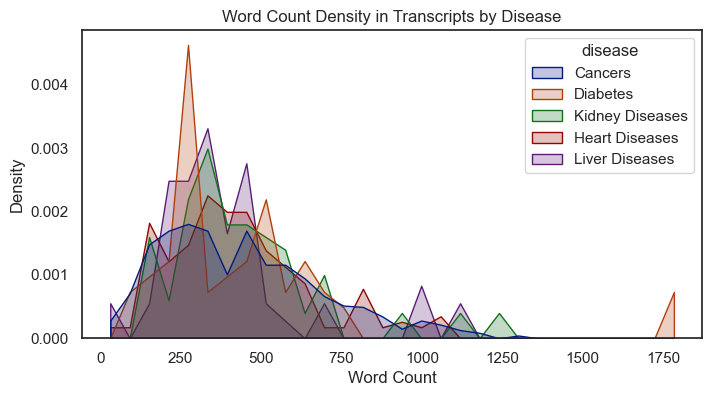

In [29]:
plt.figure(figsize=(8,4))
ax = sns.histplot(data=data_labeled, x="word_count",hue="disease",element="poly",stat="density", common_norm=False,palette='dark')
ax.set_xlabel('Word Count');ax.set_ylabel('Density'); 
ax.set_title('Word Count Density in Transcripts by Disease'); 
# ax.set_ylim(1, 500)
plt.show()

### Features per Label

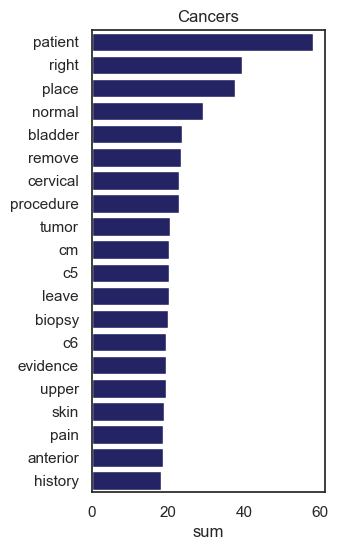

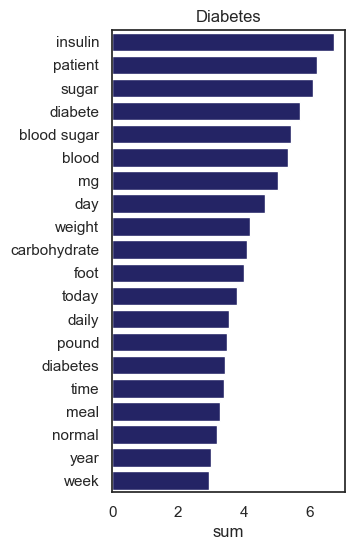

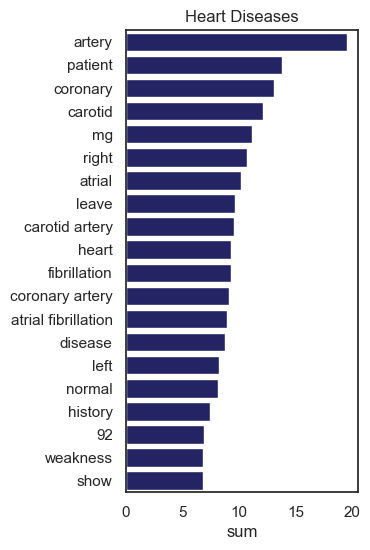

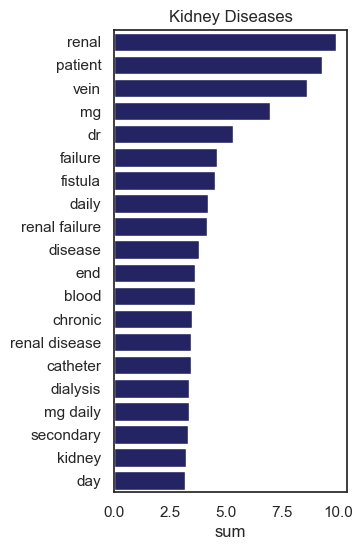

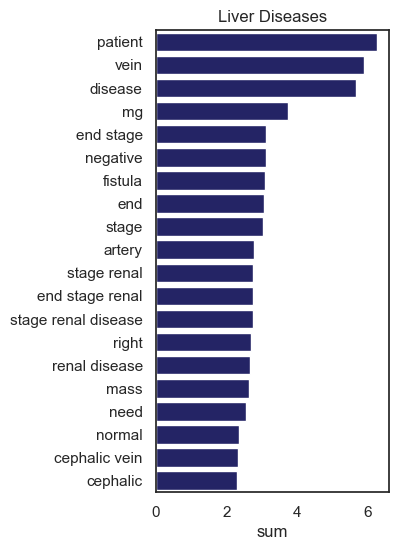

In [30]:
# Features per label
labels_df = pd.DataFrame (labels,columns = ['disease_label'])
df_combo = pd.concat([df,labels_df], axis=1)
df_combo

def get_disease_matrix(df,category):

    df_i = df[df['disease_label']==category]
    df_i = df_i.drop(columns=['disease_label'])

    df_i_T = df_i.T
    df_i_T['sum'] = df_i_T.sum(axis=1)
    df_i_T = df_i_T.sort_values(by='sum', ascending=False)
    df_i_T = df_i_T.head(25)
    df_i_T = df_i_T['sum']
    return(df_i_T)


df_cancer_T = get_disease_matrix(df_combo,'Cancers').to_frame().head(20)
df_diabetes_T = get_disease_matrix(df_combo,'Diabetes').to_frame().head(20)
df_heart_T = get_disease_matrix(df_combo,'Heart Diseases').to_frame().head(20)
df_kidney_T = get_disease_matrix(df_combo,'Kidney Diseases').to_frame().head(20)
df_liver_T = get_disease_matrix(df_combo,'Liver Diseases').to_frame().head(20)

plt.figure(figsize=(3,6))
ax = sns.barplot(data = df_cancer_T,y=df_cancer_T.index,x='sum',orient = 'h',color='midnightblue')
ax.set_title('Cancers'); 
plt.show()

plt.figure(figsize=(3,6))
ax = sns.barplot(data = df_diabetes_T,y=df_diabetes_T.index,x='sum',orient = 'h',color='midnightblue')
ax.set_title('Diabetes'); 
plt.show()

plt.figure(figsize=(3,6))
ax = sns.barplot(data = df_heart_T,y=df_heart_T.index,x='sum',orient = 'h',color='midnightblue')
ax.set_title('Heart Diseases'); 
plt.show()

plt.figure(figsize=(3,6))
ax = sns.barplot(data = df_kidney_T,y=df_kidney_T.index,x='sum',orient = 'h',color='midnightblue')
ax.set_title('Kidney Diseases'); 
plt.show()

plt.figure(figsize=(3,6))
ax = sns.barplot(data = df_liver_T,y=df_liver_T.index,x='sum',orient = 'h',color='midnightblue')
ax.set_title('Liver Diseases'); 
plt.show()


## Modeling

### Model class for tuning and testing

In [31]:
class Model(object):

    def __init__(self, model, name, x_train, y_train, x_test, y_test):
        self.model = model
        self.name = name        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
    def tune_parameters(self, search_params, search_type, scoring, cv, ignore_converge=False):        
        self.search_params = search_params
        self.search_type = search_type
        self.scoring = scoring
        self.cv = cv
        self.ignore_converge = ignore_converge
        
        self.model_tune = self.model()
        
        if self.ignore_converge:
            simplefilter("ignore", category=ConvergenceWarning)
    
        #set up search CV
        if self.search_type=='RandomizedSearchCV':
            self.search = RandomizedSearchCV(self.model_tune, self.search_params, scoring=self.scoring, cv=self.cv, random_state=1)
    
        if self.search_type=='GridSearchCV':
            self.search = GridSearchCV(self.model_tune, self.search_params, scoring=self.scoring, cv=self.cv)
            
        #fit searches
        self.result = self.search.fit(self.x_train, self.y_train) 
        
        #setting convergence warnings back to the default
        if self.ignore_converge:
            simplefilter("default", category=ConvergenceWarning) 

        #print results
        print("The best parameters are:",self.result.best_params_)
        print("The best weighted recall is:",self.result.best_score_)
           
            
    def fit_best(self,labels,catgories,pred_train=False):
        
        self.labels = labels
        self.catgories = catgories

        #fit model
        self.model_fit = self.model(**self.result.best_params_).fit(self.x_train, self.y_train)

        #predict with test data
        self.y_pred = self.model_fit.predict(self.x_test)
        self.y_pred_prb = self.model_fit.predict_proba(self.x_test)[:,1]

        #create conf matrix and classification rept.
        if len(self.catgories) == 2:
            self.cm = confusion_matrix(self.y_test, self.y_pred)
            self.cm_norm = confusion_matrix(self.y_test, self.y_pred,normalize='true')
            np.around(self.cm_norm,2,self.cm_norm)
            self.clf_rpt = classification_report(self.y_test,self.y_pred)       
        else:
            self.cm = confusion_matrix(self.y_test, self.y_pred, labels=self.catgories)
            self.cm_norm = confusion_matrix(self.y_test, self.y_pred, labels=self.catgories,normalize='true')
            np.around(self.cm_norm,2,self.cm_norm)
            self.clf_rpt = classification_report(self.y_test,self.y_pred,labels=self.catgories)            
               
        #update other attributes
        self.mas = accuracy_score(self.y_test, self.y_pred)
        self.bas = balanced_accuracy_score(self.y_test, self.y_pred)
        if len(self.catgories) == 2:
            # self.auc = round(metrics.roc_auc_score(self.y_test, self.model_fit.predict_proba(self.x_test)[:,1]),3)
            self.auc = round(metrics.roc_auc_score(self.y_test, self.y_pred_prb),3)
            self.fpr, self.tpr, self.thresh = metrics.roc_curve(self.y_test, self.y_pred_prb)
        else:
            self.auc = roc_auc_score(self.labels,self.model_fit.predict_proba(tfIdfMat_reduced), multi_class='ovr')
        self.wp,self.wr,self.wf,self.ws = precision_recall_fscore_support(self.y_test, self.y_pred, average='weighted',labels=self.catgories)
    
        if pred_train:
            self.__pred_train()
            
        print(self.name, "Testing Classification Report:")
        print(self.clf_rpt)        
        
    def __pred_train(self):
        
            #predict with training data
            self.y_pred_train = self.model_fit.predict(self.x_train)
            self.y_pred_prb_train = self.model_fit.predict_proba(self.x_train)[:,1]
            
            #create conf matrix and classification rept.
            if len(self.catgories) == 2:
                self.cm_train = confusion_matrix(self.y_train, self.y_pred_train)
                self.cm_norm_train = confusion_matrix(self.y_train, self.y_pred_train,normalize='true') 
                np.around(self.cm_norm_train,2,self.cm_norm_train)
                self.clf_rpt_train = classification_report(self.y_train,self.y_pred_train)
            else:
                self.cm_train = confusion_matrix(self.y_train, self.y_pred_train, labels=self.catgories)
                self.cm_norm_train = confusion_matrix(self.y_train, self.y_pred_train, labels=self.catgories,normalize='true') 
                np.around(self.cm_norm_train,2,self.cm_norm_train)
                self.clf_rpt_train = classification_report(self.y_train,self.y_pred_train,labels=self.catgories)
            
            #update other attributes
            self.mas_train = accuracy_score(self.y_train, self.y_pred_train)
            self.bas_train = balanced_accuracy_score(self.y_train, self.y_pred_train)
            self.wp_train,self.wr_train,self.wf_train,self.ws_train = precision_recall_fscore_support(self.y_train, self.y_pred_train, average='weighted',labels=self.catgories)

            print(self.name,"Training Model Accuracy:", round(self.mas_train,2))
            print(self.name,"Training Balanced Accuracy:", round(self.bas_train,2),"\n")

            print(self.name,"Training Weighted Metrics:")
            print(" precision:",round(self.wp_train,2),"\n recall:",round(self.wr_train,2),"\n f1-score:",round(self.wf_train,2),"\n")
            
            print(self.name,"Training Classification Report:")
            print(self.clf_rpt_train)
        
    def update_results_df(self,results_df):      
        results_df.loc[self.name] = [self.mas,self.bas,self.auc,self.wp,self.wr,self.wf]  
        return results_df

    def printable_report(self,incl_train=False):
        report = pd.DataFrame(classification_report(self.y_test,self.y_pred,labels=self.catgories, output_dict=True)).transpose()
        if incl_train:
            tr_report = pd.DataFrame(classification_report(self.y_train,self.y_pred_train,labels=self.catgories, output_dict=True)).transpose()
            return(report, tr_report)
        else:            
            return(report)
    


### Plot Confusion Matrix Function

In [32]:
def plot_cm(cm,title_string,color,set_ticks=True):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=True, yticklabels=True, ax=ax, cmap=color)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(title_string)
    if set_ticks:     
        tick_labels = [label.replace(' ', '\n') for label in category_list ] #wrap labels
        ax.set_xticklabels(tick_labels)
        ax.set_yticklabels(tick_labels)
    plt.show()


### Multiclass Classification
* This section explores modeling with all 5 categories we've identified (cancer, diabetes, heart, kidney, and liver)

In [33]:
#To capture results for comparison                                     
mc_results_df = pd.DataFrame(columns = ['Model','Accuracy','Balanced Accuracy','AUC','Weighted Precision','Weighted Recall','Weighted F1-Score'])
mc_results_df = pd.DataFrame(mc_results_df).set_index('Model')
mc_results_df

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,


#### Logistic regression
* Run randomize search cv to find best parameters for Logistic Regression model.
* Display full results and confusion matrix for best results.
* Note that convergence warnigs are temporarily ignored while running the searchcv. Convergence warnings are raised for some ratio values and C values. 


In [34]:
# Tune hyperparameters
ratio_values = np.arange(0, 1, 0.1).tolist()
c_values = np.logspace(-4, 4, 50)
params_lr = [
  {'solver': ['saga'], 'penalty': ['elasticnet'],'l1_ratio': ratio_values,'C':c_values,'max_iter': [1000],'random_state': [1],'multi_class':['ovr'],'class_weight':['balanced']},
   {'solver': ['lbfgs'], 'penalty':  ['l2'],'C':c_values, 'max_iter': [1000],'random_state': [1],'multi_class':['ovr'],'class_weight':['balanced']},
  {'solver': ['liblinear'], 'penalty': ['l1', 'l2'],'C':c_values, 'max_iter': [1000],'random_state': [1],'multi_class':['ovr'],'class_weight':['balanced']},
]

model_lr_multi = Model(LogisticRegression, "Logistic Regression", x_train_sc, y_train, x_test_sc, y_test)
model_lr_multi.tune_parameters(params_lr, 'RandomizedSearchCV', 'recall_weighted', 5, True)


The best parameters are: {'solver': 'liblinear', 'random_state': 1, 'penalty': 'l1', 'multi_class': 'ovr', 'max_iter': 1000, 'class_weight': 'balanced', 'C': 1.2067926406393288}
The best weighted recall is: 0.8441883116883118


Logistic Regression Testing Classification Report:
                 precision    recall  f1-score   support

        Cancers       0.97      0.95      0.96       193
       Diabetes       0.87      0.76      0.81        17
Kidney Diseases       0.61      0.52      0.56        21
 Heart Diseases       0.88      0.88      0.88        48
 Liver Diseases       0.40      0.67      0.50        15

       accuracy                           0.88       294
      macro avg       0.75      0.76      0.74       294
   weighted avg       0.90      0.88      0.89       294

Class distribution: [14 18 18 25 24]


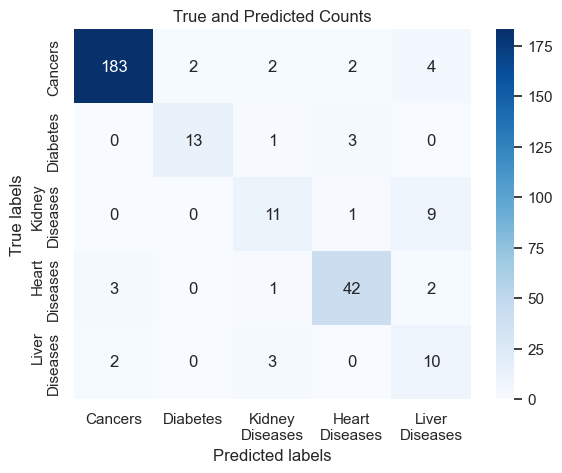

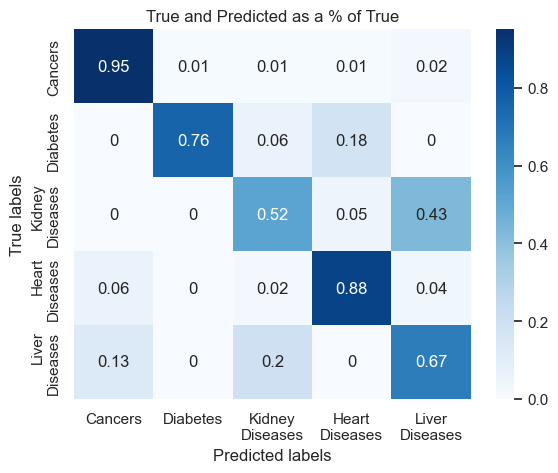

In [35]:
# Fit best model and display results
model_lr_multi.fit_best(labels,category_list)

#Display model attributes:
print("Class distribution:",model_lr_multi.model_fit.n_iter_)

# Plot confusion matrix - counts
plot_cm(model_lr_multi.cm,'True and Predicted Counts','Blues')

# Plot confusion matrix - %s
plot_cm(model_lr_multi.cm_norm,'True and Predicted as a % of True','Blues')

In [36]:
# save to results df
mc_results_df = model_lr_multi.update_results_df(mc_results_df)
display(mc_results_df)

# save classification rpt to csv
lr_report = model_lr_multi.printable_report()
# lr_report.to_csv('lr_report.csv', index= True)

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.880952,0.755674,0.992068,0.896033,0.880952,0.886259


#### Naive Bayes
* Run grid grid search cv to find best parameters for Naive Bayes model using scaled input data.
* Display full results and confusion matrix for best results.

In [37]:
# Tune hyperparameters
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

model_nb_multi = Model(GaussianNB, "Naive Bayes", x_train_sc, y_train, x_test_sc, y_test)
model_nb_multi.tune_parameters(params_nb, 'GridSearchCV', 'recall_weighted', 5)

The best parameters are: {'var_smoothing': 0.0005336699231206307}
The best weighted recall is: 0.8180064935064936


Naive Bayes Testing Classification Report:
                 precision    recall  f1-score   support

        Cancers       0.90      0.90      0.90       193
       Diabetes       0.50      0.53      0.51        17
Kidney Diseases       0.62      0.38      0.47        21
 Heart Diseases       0.86      0.75      0.80        48
 Liver Diseases       0.30      0.53      0.38        15

       accuracy                           0.80       294
      macro avg       0.63      0.62      0.61       294
   weighted avg       0.82      0.80      0.80       294

Class distribution: [0.65756542 0.05802048 0.16268487 0.0705347  0.05119454]


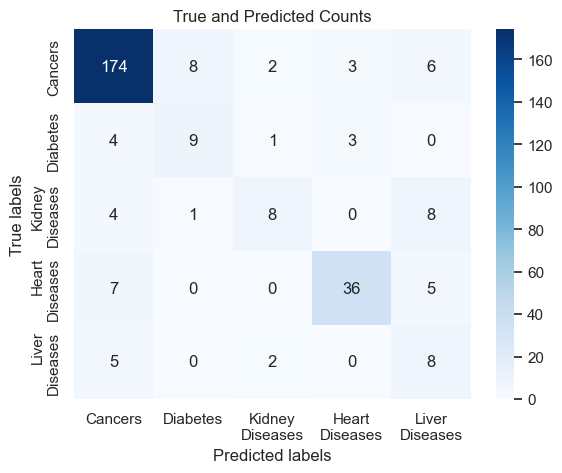

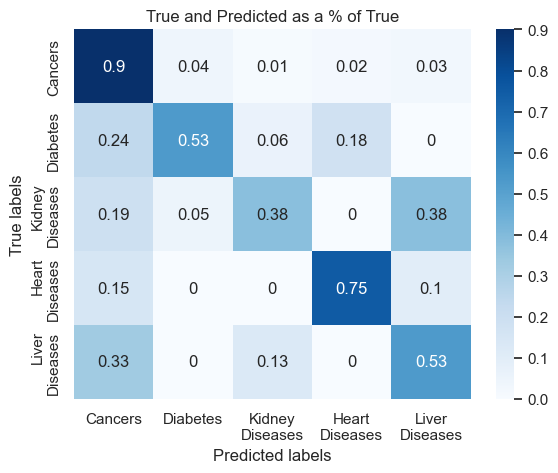

In [38]:
# Fit best model and display results
model_nb_multi.fit_best(labels,category_list)

#Display model attributes:
print("Class distribution:",model_nb_multi.model_fit.class_prior_)

# Plot confusion matrix - counts
plot_cm(model_nb_multi.cm,'True and Predicted Counts','Blues')

# Plot confusion matrix - %s
plot_cm(model_nb_multi.cm_norm,'True and Predicted as a % of True','Blues')

In [39]:
# add to results df
mc_results_df = model_nb_multi.update_results_df(mc_results_df)
display(mc_results_df)

# save classification rpt to csv
nb_report = model_nb_multi.printable_report()
# nb_report.to_csv('nb_report.csv', index= True)

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.880952,0.755674,0.992068,0.896033,0.880952,0.886259
Naive Bayes,0.799320,0.619050,0.952229,0.816712,0.799320,0.803707


#### Decision Trees
* Run randomized grid search cv to find best parameters for Decision Tree model.
* Display full results and confusion matrix for best results.

In [40]:
# Tune hyperparameters
params_dt = {'class_weight': ['balanced'], 
        'criterion': ['entropy','gini','log_loss'], 
        'max_depth': randint(2, 10), 
        'min_samples_leaf': randint(1, 5), 
        'min_samples_split': randint(2, 10), 
        'random_state':[1]}

model_dt_multi = Model(DecisionTreeClassifier, "Decision Tree", x_train, y_train, x_test, y_test)
model_dt_multi.tune_parameters(params_dt, 'RandomizedSearchCV', 'recall_weighted', 5)


The best parameters are: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'random_state': 1}
The best weighted recall is: 0.7827922077922078


Decision Tree Testing Classification Report:
                 precision    recall  f1-score   support

        Cancers       0.97      0.88      0.92       193
       Diabetes       0.65      0.65      0.65        17
Kidney Diseases       0.75      0.43      0.55        21
 Heart Diseases       0.78      0.94      0.85        48
 Liver Diseases       0.42      0.87      0.57        15

       accuracy                           0.84       294
      macro avg       0.71      0.75      0.71       294
   weighted avg       0.87      0.84      0.85       294



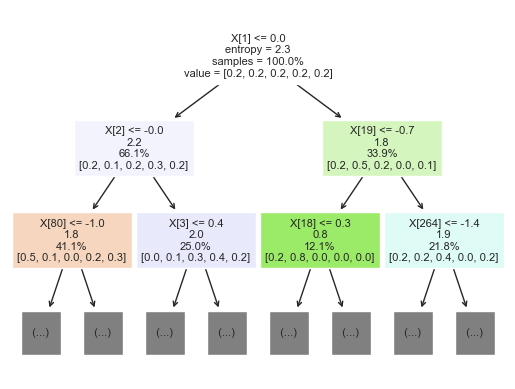

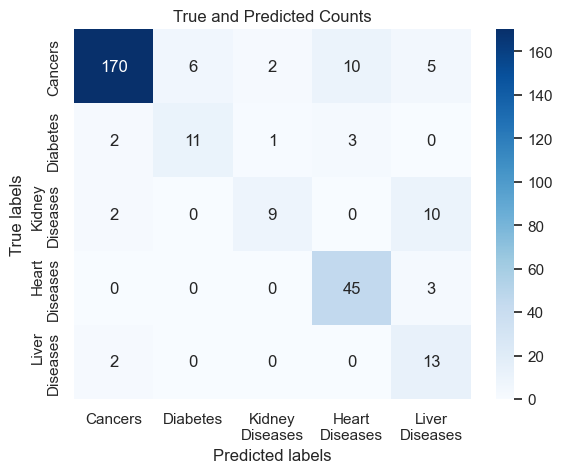

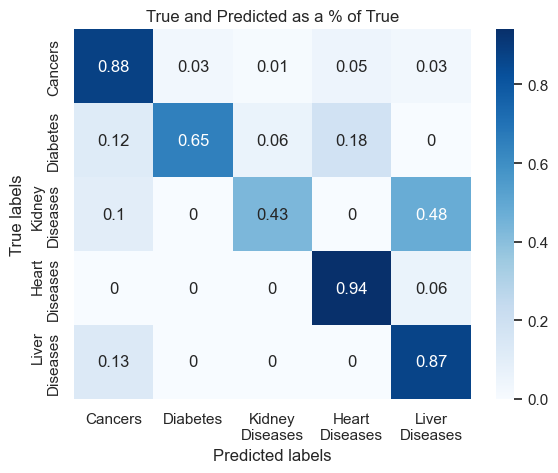

In [41]:
# Fit best model and display results
model_dt_multi.fit_best(labels,category_list)

#Display model attributes:
tree.plot_tree(model_dt_multi.model_fit, max_depth=2, label='root',fontsize=8,filled =True,precision =1,proportion=True)
plt.show()

# Plot confusion matrix - counts
plot_cm(model_dt_multi.cm,'True and Predicted Counts','Blues')

# Plot confusion matrix - %s
plot_cm(model_dt_multi.cm_norm,'True and Predicted as a % of True','Blues')

In [42]:
mc_results_df = model_dt_multi.update_results_df(mc_results_df)
display(mc_results_df)

# save classification rpt to csv
dt_report = model_dt_multi.printable_report()
# dt_report.to_csv('dt_report.csv', index= True)

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.880952,0.755674,0.992068,0.896033,0.880952,0.886259
Naive Bayes,0.799320,0.619050,0.952229,0.816712,0.799320,0.803707
Decision Tree,0.843537,0.752125,0.976912,0.873137,0.843537,0.848706


#### Neural Networks
* Run randomized search cv to find best parameters for Neural Networks model using scaled input data.
* Display full results and confusion matrix for best results.

In [43]:
# Tune hyperparameters
params_nn  = {'activation': ['logistic'], #keep
        'solver': ['adam','lbfgs'], 
        'alpha': 10.0 ** -np.arange(1, 7), 
        'max_iter': [2000], #NOT DEFAULT
        'random_state': [1]} #NOT DEFAULT

model_nn_multi = Model(MLPClassifier, "Neural Networks", x_train_sc, y_train, x_test_sc, y_test)
model_nn_multi.tune_parameters(params_nn, 'RandomizedSearchCV', 'recall_weighted', 5)


The best parameters are: {'solver': 'lbfgs', 'random_state': 1, 'max_iter': 2000, 'alpha': 0.01, 'activation': 'logistic'}
The best weighted recall is: 0.8293701298701299


In [44]:
# Fit best model and display results
model_nn_multi.fit_best(labels,category_list,pred_train=True)

Neural Networks Training Model Accuracy: 0.94
Neural Networks Training Balanced Accuracy: 0.86 

Neural Networks Training Weighted Metrics:
 precision: 0.94 
 recall: 0.94 
 f1-score: 0.94 

Neural Networks Training Classification Report:
                 precision    recall  f1-score   support

        Cancers       0.98      0.98      0.98       578
       Diabetes       0.98      0.96      0.97        51
Kidney Diseases       0.71      0.82      0.76        62
 Heart Diseases       0.92      0.94      0.93       143
 Liver Diseases       0.82      0.62      0.71        45

       accuracy                           0.94       879
      macro avg       0.88      0.86      0.87       879
   weighted avg       0.94      0.94      0.94       879

Neural Networks Testing Classification Report:
                 precision    recall  f1-score   support

        Cancers       0.93      0.95      0.94       193
       Diabetes       0.85      0.65      0.73        17
Kidney Diseases       0.47


Training Confusion Matrices:


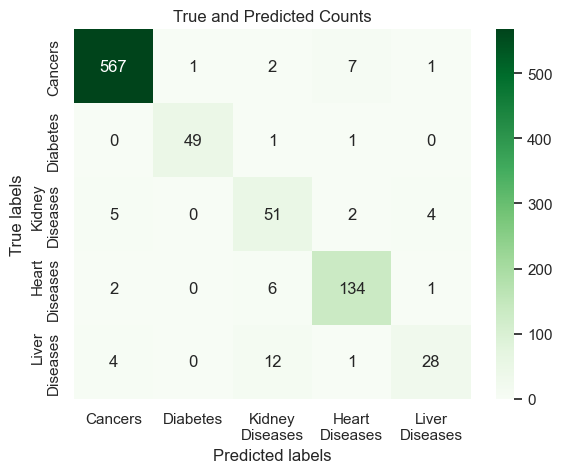

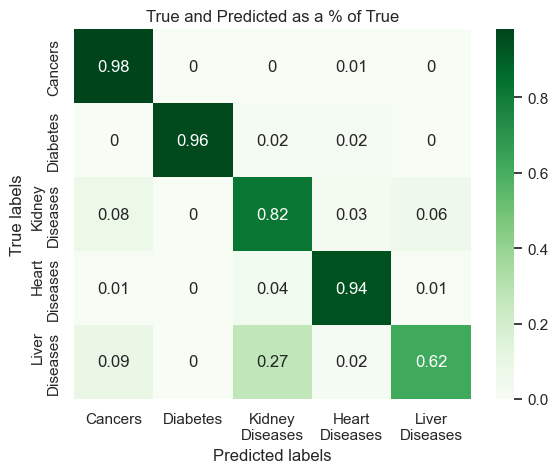

In [45]:
print("\nTraining Confusion Matrices:")
# Plot confusion matrix - counts - training
plot_cm(model_nn_multi.cm_train,'True and Predicted Counts','Greens')

# Plot confusion matrix - %s - training
plot_cm(model_nn_multi.cm_norm_train,'True and Predicted as a % of True','Greens')

Number of iterations: 27
Number of layers: 3

Testing Confusion Matrices:


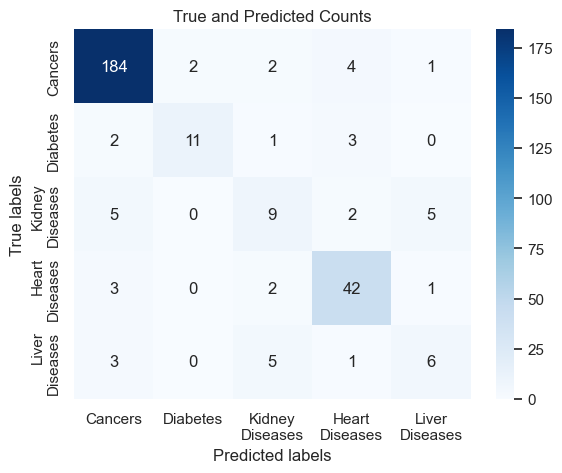

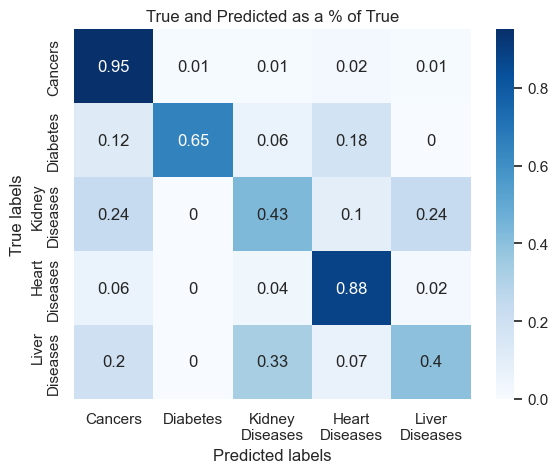

In [46]:
# Display model attributes:
# print("Class distribution:",model_nn_multi.model_fit.class_prior_)
print("Number of iterations:",model_nn_multi.model_fit.n_iter_)
print("Number of layers:",model_nn_multi.model_fit.n_layers_)

print("\nTesting Confusion Matrices:")
# Plot confusion matrix - counts
plot_cm(model_nn_multi.cm,'True and Predicted Counts','Blues')

# Plot confusion matrix - %s
plot_cm(model_nn_multi.cm_norm,'True and Predicted as a % of True','Blues')

In [47]:
# add to results df
mc_results_df = model_nn_multi.update_results_df(mc_results_df)
display(mc_results_df)

# save classification rpt to csv
nn_ts_report,nn_tr_report = model_nn_multi.printable_report(True)
# nn_ts_report.to_csv('nn_ts_report.csv', index= True)
# nn_tr_report.to_csv('nn_tr_report.csv', index= True)


,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.880952,0.755674,0.992068,0.896033,0.880952,0.886259
Naive Bayes,0.799320,0.619050,0.952229,0.816712,0.799320,0.803707
Decision Tree,0.843537,0.752125,0.976912,0.873137,0.843537,0.848706
Neural Networks,0.857143,0.660800,0.990733,0.851321,0.857143,0.852987


### Binary Classification
* This section explores modeling with cancer as a binary classifyer.

In [48]:
bc_results_df = pd.DataFrame(columns = ['Model','Accuracy','Balanced Accuracy','AUC','Weighted Precision','Weighted Recall','Weighted F1-Score'])
bc_results_df = pd.DataFrame(bc_results_df).set_index('Model')
bc_results_df

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,


#### Logistic regression
* Run randomized search cv to find best parameters for Logistic Regression model.
* Display full results and confusion matrix for best results.

In [49]:
# Tune hyperparameters
model_lr_binary = Model(LogisticRegression, "Logistic Regression", x_train_b_sc, y_train_b, x_test_b_sc, y_test_b)
model_lr_binary.tune_parameters(params_lr, 'RandomizedSearchCV', 'recall', 5, True)


The best parameters are: {'solver': 'saga', 'random_state': 1, 'penalty': 'elasticnet', 'multi_class': 'ovr', 'max_iter': 1000, 'l1_ratio': 0.2, 'class_weight': 'balanced', 'C': 0.8286427728546842}
The best weighted recall is: 0.9307946026986507


Logistic Regression Testing Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       101
           1       0.93      0.94      0.94       193

    accuracy                           0.91       294
   macro avg       0.91      0.90      0.91       294
weighted avg       0.91      0.91      0.91       294

Class distribution: [229]


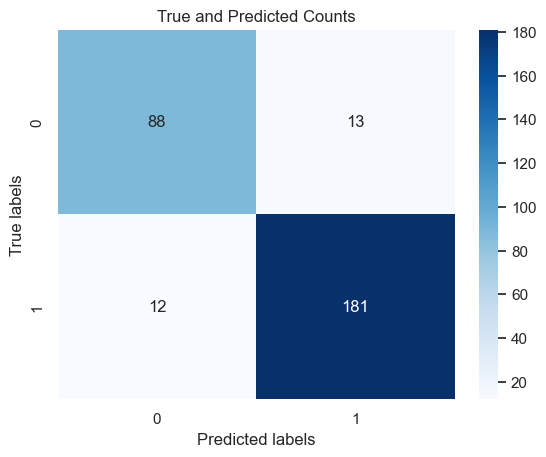

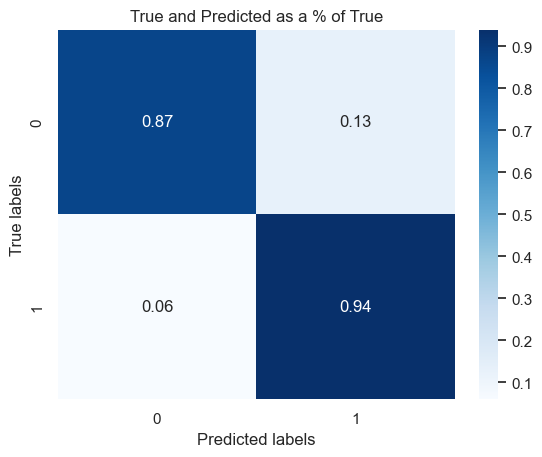

In [50]:
# Fit best model and display results
model_lr_binary.fit_best(labels_b,category_list_b)

#Display model attributes:
print("Class distribution:",model_lr_binary.model_fit.n_iter_)

# Plot confusion matrix - counts
plot_cm(model_lr_binary.cm,'True and Predicted Counts','Blues',False)

# Plot confusion matrix - %s
plot_cm(model_lr_binary.cm_norm,'True and Predicted as a % of True','Blues',False)

In [51]:
# save to results df
bc_results_df = model_lr_binary.update_results_df(bc_results_df)
display(bc_results_df)

# save classification rpt to csv
lr_report_b = model_lr_binary.printable_report()
# lr_report_b.to_csv('lr_report_b.csv', index= True)

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.914966,0.904555,0.95,0.914786,0.914966,0.914864


#### Naive Bayes
* Run grid grid search cv to find best parameters for Naive Bayes model using scaled input data.
* Display full results and confusion matrix for best results.

In [52]:
# Tune hyperparameters
model_nb_binary = Model(GaussianNB, "Naive Bayes", x_train_b_sc, y_train_b, x_test_b_sc, y_test_b)
model_nb_binary.tune_parameters(params_nb, 'GridSearchCV', 'recall', 5)

The best parameters are: {'var_smoothing': 0.002848035868435802}
The best weighted recall is: 0.9049625187406297


Naive Bayes Testing Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       101
           1       0.85      0.91      0.88       193

    accuracy                           0.84       294
   macro avg       0.83      0.81      0.82       294
weighted avg       0.84      0.84      0.84       294

Class distribution: [0.34243458 0.65756542]


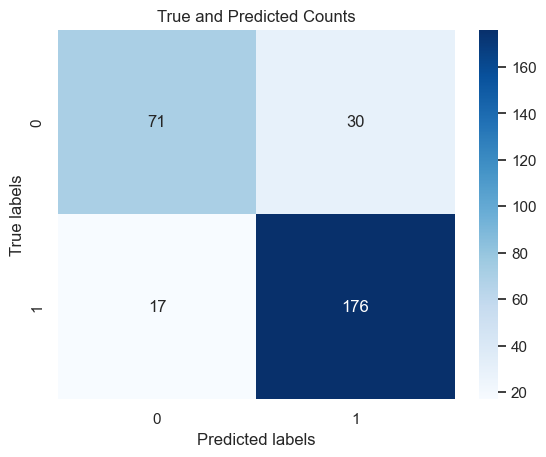

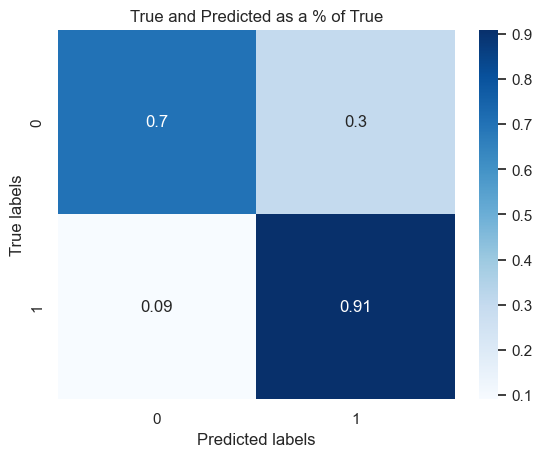

In [53]:
# Fit best model and display results
model_nb_binary.fit_best(labels_b,category_list_b)

#Display model attributes:
print("Class distribution:",model_nb_binary.model_fit.class_prior_)

# Plot confusion matrix - counts
plot_cm(model_nb_binary.cm,'True and Predicted Counts','Blues',False)

# Plot confusion matrix - %s
plot_cm(model_nb_binary.cm_norm,'True and Predicted as a % of True','Blues',False)

In [54]:
# save to results df
bc_results_df = model_nb_binary.update_results_df(bc_results_df)
display(bc_results_df)

# save classification rpt to csv
nb_report_b = model_nb_binary.printable_report()
# nb_report_b.to_csv('nb_report_b.csv', index= True)

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.914966,0.904555,0.950,0.914786,0.914966,0.914864
Naive Bayes,0.840136,0.807444,0.868,0.838033,0.840136,0.837242


#### Decision Trees
* Run randomized search cv to find best parameters for Decision Tree model.
* Display full results and confusion matrix for best results.

In [55]:
# # Tune hyperparameters
model_dt_binary = Model(DecisionTreeClassifier, "Decision Tree", x_train_b, y_train_b, x_test_b, y_test_b)
model_dt_binary.tune_parameters(params_dt, 'RandomizedSearchCV', 'recall', 5)


The best parameters are: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'random_state': 1}
The best weighted recall is: 0.8996851574212894


Decision Tree Testing Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       101
           1       0.94      0.93      0.93       193

    accuracy                           0.91       294
   macro avg       0.90      0.90      0.90       294
weighted avg       0.91      0.91      0.91       294



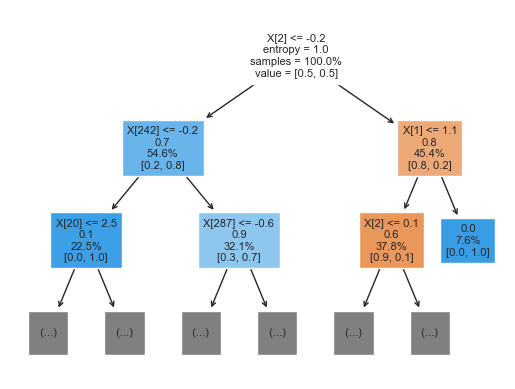

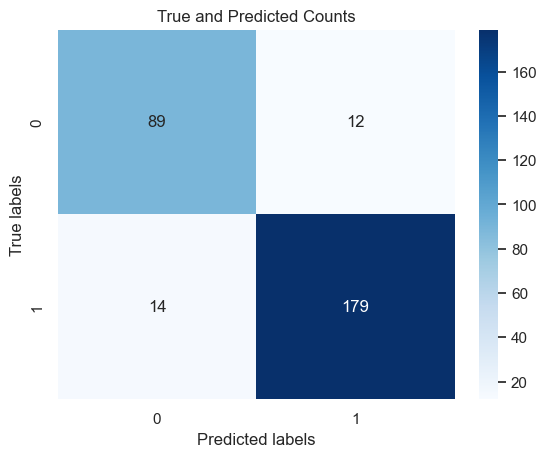

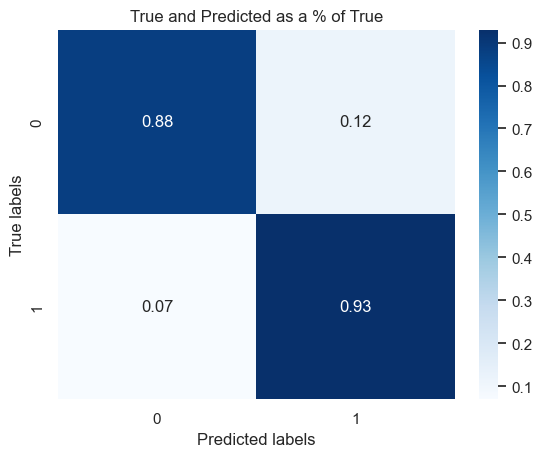

In [56]:
# Fit best model and display results
model_dt_binary.fit_best(labels_b,category_list_b)

#Display model attributes:
tree.plot_tree(model_dt_binary.model_fit, max_depth=2, label='root',fontsize=8,filled =True,precision =1,proportion=True)
plt.show()

# Plot confusion matrix - counts
plot_cm(model_dt_binary.cm,'True and Predicted Counts','Blues',False)

# Plot confusion matrix - %s
plot_cm(model_dt_binary.cm_norm,'True and Predicted as a % of True','Blues',False)

In [57]:
# add to results df
bc_results_df = model_dt_binary.update_results_df(bc_results_df)
display(bc_results_df)

# save classification rpt to csv
dt_report_b = model_dt_binary.printable_report()
# dt_report_b.to_csv('dt_report_b.csv', index= True)

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.914966,0.904555,0.950,0.914786,0.914966,0.914864
Naive Bayes,0.840136,0.807444,0.868,0.838033,0.840136,0.837242
Decision Tree,0.911565,0.904325,0.944,0.912062,0.911565,0.911768


#### Neural Networks
* Run randomized search cv to find best parameters for Neural Networks model using scaled input data.
* Display full results and confusion matrix for best results.

In [58]:
# Tune hyperparameters
model_nn_binary = Model(MLPClassifier, "Neural Networks", x_train_b_sc, y_train_b, x_test_b_sc, y_test_b)
model_nn_binary.tune_parameters(params_nn, 'RandomizedSearchCV', 'recall', 5)


The best parameters are: {'solver': 'lbfgs', 'random_state': 1, 'max_iter': 2000, 'alpha': 0.01, 'activation': 'logistic'}
The best weighted recall is: 0.9359970014992504


In [59]:
# Fit best model and display results
model_nn_binary.fit_best(labels_b,category_list_b,pred_train=True)

Neural Networks Training Model Accuracy: 0.98
Neural Networks Training Balanced Accuracy: 0.98 

Neural Networks Training Weighted Metrics:
 precision: 0.98 
 recall: 0.98 
 f1-score: 0.98 

Neural Networks Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       301
           1       0.99      0.98      0.98       578

    accuracy                           0.98       879
   macro avg       0.97      0.98      0.98       879
weighted avg       0.98      0.98      0.98       879

Neural Networks Testing Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       101
           1       0.91      0.94      0.93       193

    accuracy                           0.90       294
   macro avg       0.89      0.88      0.89       294
weighted avg       0.90      0.90      0.90       294




Training Confusion Matrices:


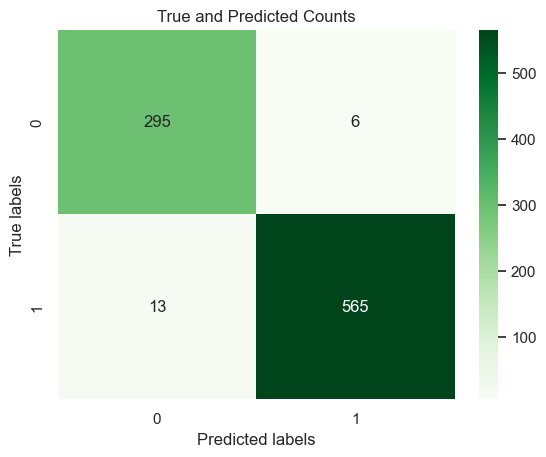

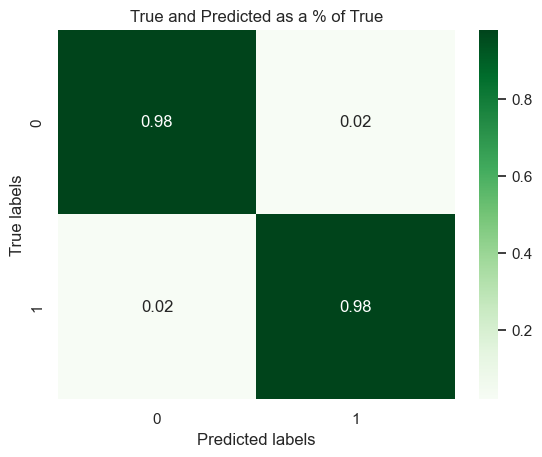

In [60]:
print("\nTraining Confusion Matrices:")
# Plot confusion matrix - counts - training
plot_cm(model_nn_binary.cm_train,'True and Predicted Counts','Greens',False)

# Plot confusion matrix - %s - training
plot_cm(model_nn_binary.cm_norm_train,'True and Predicted as a % of True','Greens',False)

Number of iterations: 63
Number of layers: 3

Testing Confusion Matrices:


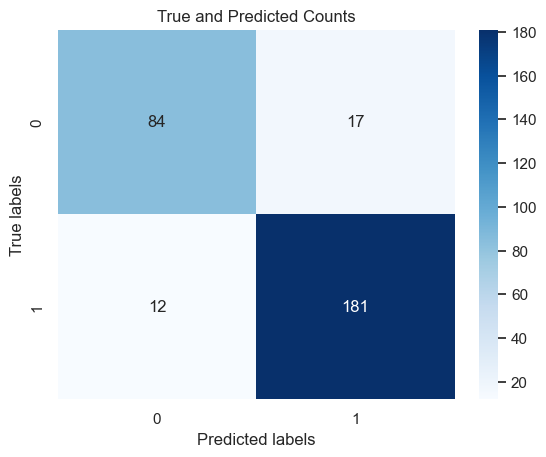

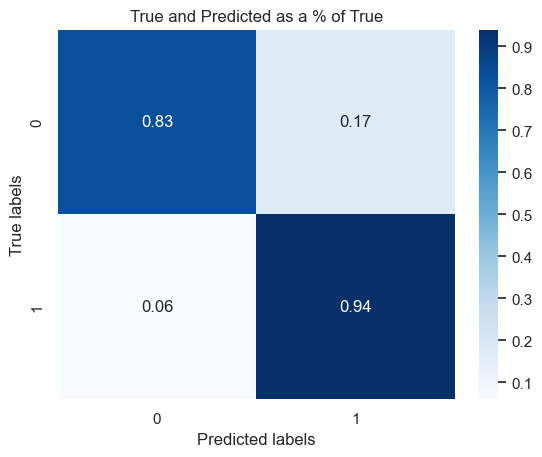

In [61]:
# Display model attributes:
print("Number of iterations:",model_nn_binary.model_fit.n_iter_)
print("Number of layers:",model_nn_binary.model_fit.n_layers_)

print("\nTesting Confusion Matrices:")
# Plot confusion matrix - counts
plot_cm(model_nn_binary.cm,'True and Predicted Counts','Blues',False)

# Plot confusion matrix - %s
plot_cm(model_nn_binary.cm_norm,'True and Predicted as a % of True','Blues',False)

In [62]:
# save to results df
bc_results_df = model_nn_binary.update_results_df(bc_results_df)
display(bc_results_df)

# save classification rpt to csv
nn_report_b = model_nn_binary.printable_report()
# nn_report_b.to_csv('nn_report_b.csv', index= True)

,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,
Logistic Regression,0.914966,0.904555,0.950,0.914786,0.914966,0.914864
Naive Bayes,0.840136,0.807444,0.868,0.838033,0.840136,0.837242
Decision Tree,0.911565,0.904325,0.944,0.912062,0.911565,0.911768
Neural Networks,0.901361,0.884754,0.947,0.900695,0.901361,0.900739


#### ROC Curves

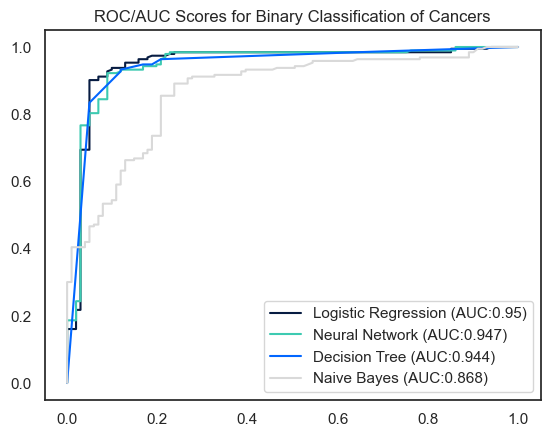

In [63]:
plt.figure(0).clf()

plt.plot(model_lr_binary.fpr,model_lr_binary.tpr,label="Logistic Regression (AUC:"+str(model_lr_binary.auc)+")",color="#071c42")
plt.plot(model_nn_binary.fpr,model_nn_binary.tpr,label="Neural Network (AUC:"+str(model_nn_binary.auc)+")",color="#3dcab1")
plt.plot(model_dt_binary.fpr,model_dt_binary.tpr,label="Decision Tree (AUC:"+str(model_dt_binary.auc)+")",color="#0166ff")
plt.plot(model_nb_binary.fpr,model_nb_binary.tpr,label="Naive Bayes (AUC:"+str(model_nb_binary.auc)+")",color="#d9d9d9")

plt.title('ROC/AUC Scores for Binary Classification of Cancers'); 
plt.legend(loc=0)
plt.show()


### Combine Results Dataframes

In [64]:
mc_results_df['Model Group'] = 'Multi-class'
bc_results_df['Model Group'] = 'Binary'

all_results_df = pd.concat([mc_results_df,bc_results_df])
all_results_df = all_results_df[['Model Group','Accuracy','Balanced Accuracy','AUC','Weighted Precision','Weighted Recall','Weighted F1-Score']]

all_results_df
# all_results_df.to_csv(os.path.join('all_results_dfa.csv')) 

,Model Group,Accuracy,Balanced Accuracy,AUC,Weighted Precision,Weighted Recall,Weighted F1-Score
Model,,,,,,,
Logistic Regression,Multi-class,0.880952,0.755674,0.992068,0.896033,0.880952,0.886259
Naive Bayes,Multi-class,0.799320,0.619050,0.952229,0.816712,0.799320,0.803707
Decision Tree,Multi-class,0.843537,0.752125,0.976912,0.873137,0.843537,0.848706
Neural Networks,Multi-class,0.857143,0.660800,0.990733,0.851321,0.857143,0.852987
Logistic Regression,Binary,0.914966,0.904555,0.950000,0.914786,0.914966,0.914864
Naive Bayes,Binary,0.840136,0.807444,0.868000,0.838033,0.840136,0.837242
Decision Tree,Binary,0.911565,0.904325,0.944000,0.912062,0.911565,0.911768
Neural Networks,Binary,0.901361,0.884754,0.947000,0.900695,0.901361,0.900739
